In [1]:
import tensorflow as tf
from utils import *
from models import Autoencoder, VaDE
from sklearn.mixture import GaussianMixture
import math

2024-05-26 01:21:59.888945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 01:22:06.245362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
original_dim = 784
latent_dim = 10
n_clusters = 10
x_train, y_train, x_test, y_test = get_data()

In [3]:
vade = VaDE(original_dim, latent_dim, n_clusters)

2024-05-26 01:22:22.249815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 01:22:22.665024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 01:22:22.665824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 01:22:22.681982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-26 01:22:22.682108: I external/local_xla/xla/stream_executor

In [5]:
reconstruction, z_mean, z_log_var, z = vade(x_train)

In [5]:
# KL_div =  tensor(5753.8750, grad_fn=<SubBackward0>)

In [36]:
def elbo_vade(model, x, recon_x, mu, logvar, z):
    weights = tf.nn.softmax(model.pi_, axis=0)
    z = tf.expand_dims(z, 1)
    batch_size = tf.shape(x)[0]
    h = z - model.mu_c
    h = tf.exp(-0.5 * tf.reduce_sum((h * h / tf.exp(model.log_var_c)), axis=2))
    h = h / tf.exp(tf.reduce_sum(0.5 * model.log_var_c, axis=1))
    p_z_given_c = h / (2 * math.pi)
    p_z_c = p_z_given_c * weights + 1e-9
    gamma = p_z_c / (tf.reduce_sum(p_z_c, axis=1, keepdims=True))
    h = tf.expand_dims(tf.exp(logvar), 1) + tf.square(tf.expand_dims(mu, 1) - model.mu_c)
    h = tf.reduce_sum(model.log_var_c + h / tf.exp(model.log_var_c), axis=2)
    kl_div = 0.5 * tf.reduce_sum(gamma * h) \
           - tf.reduce_sum(gamma * tf.math.log(weights + 1e-9)) \
           + tf.reduce_sum(gamma * tf.math.log(gamma + 1e-9)) \
           - 0.5 * tf.reduce_sum(1 + logvar)
    
    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x) * x.shape[1])
    
    loss = recon_loss + kl_div
    loss = loss / tf.cast(batch_size, tf.float32)
    return loss

In [37]:
elbo_vade(vade, x_train, reconstruction, z_mean, z_log_var, z)

(<tf.Tensor: shape=(), dtype=float32, numpy=543.2778>,
 <tf.Tensor: shape=(), dtype=float32, numpy=32586926.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9741.219>)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.nn.parameter import Parameter
import math

In [7]:
def reparametrize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)

    return mu + eps * std

class EncoderBlock(nn.Module):
    def __init__(self, channel_dims):
        super().__init__()
        self.channel_dims = channel_dims
        self.fc_layers = []
        for i in range(len(self.channel_dims) - 1):
            self.fc_layers.append(nn.Linear(self.channel_dims[i], self.channel_dims[i + 1]))
            if i != len(self.channel_dims) - 2:
                self.fc_layers.append(nn.ReLU())
        self.fc_layers = nn.Sequential(*self.fc_layers)

    def forward(self, x):
        x = self.fc_layers(x)

        return x
    

class DecoderBlock(nn.Module):
    def __init__(self, channel_dims, output_shape):
        super().__init__()
        self.channel_dims = channel_dims
        self.fc_layers = []
        for i in range(len(self.channel_dims) - 1):
            if i != 0:
                self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Linear(self.channel_dims[i], self.channel_dims[i + 1]))
        self.fc_layers = nn.Sequential(*self.fc_layers)
        self.out_reshape = nn.Unflatten(1, output_shape)

    def forward(self, x):
        x = self.fc_layers(x)
        x = self.out_reshape(x)

        return x
    
class VADE_torch(nn.Module):
    def __init__(self, latent_dim, n_classes, channel_dims, output_shape, device=None, gmm_n_init=1):
        super().__init__()
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.device = device
        self.gmm_n_init = gmm_n_init
        decoder_channel_dims = channel_dims[::-1]
        if self.device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.pi = Parameter(torch.FloatTensor(self.n_classes,).fill_(1) / self.n_classes, requires_grad=True)
        self.mu = Parameter(torch.FloatTensor(self.n_classes, self.latent_dim).fill_(0), requires_grad=True)
        self.logvar = Parameter(torch.FloatTensor(self.n_classes, self.latent_dim).fill_(0), requires_grad=True)

        self.encoder = EncoderBlock(channel_dims)
        self.fc_mu = nn.Linear(channel_dims[-1], self.latent_dim)
        self.fc_logvar = nn.Linear(channel_dims[-1], self.latent_dim)
        self.decoder_latent = nn.Linear(self.latent_dim, decoder_channel_dims[0])
        self.decoder = DecoderBlock(decoder_channel_dims, output_shape)

    @property
    def weights(self):
        return F.softmax(self.pi, dim=0)

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar
    
    def decode(self, z):
        x = self.decoder_latent(z)
        x = self.decoder(x)

        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = reparametrize(mu, logvar)
        x = self.decode(z)

        return x, mu, logvar

In [ ]:
model = VADE_torch(latent_dim, n_clusters, [original_dim, 500, 500, 2000], (28 * 28,))

In [30]:
# move params from vade to model, note that model is torch model and vade is tf model
model.pi.data = torch.tensor(vade.pi_.numpy(), requires_grad=True)
model.mu.data = torch.tensor(vade.mu_c.numpy(), requires_grad=True)
model.logvar.data = torch.tensor(vade.log_var_c.numpy(), requires_grad=True)

In [31]:
def classify(z):

    log_p_z_given_c = (torch.sum((-0.5 * model.logvar), dim=1) - 
                        0.5 * (math.log(2 * math.pi) + torch.sum(torch.pow((z.unsqueeze(2) - model.mu), 2) / (torch.exp(model.logvar) + 1e-9), dim=3)))
    
    p_z_c = torch.exp(log_p_z_given_c) * model.weights
    y = p_z_c / (torch.sum(p_z_c, dim=2, keepdim=True) + 1e-9)
    y = torch.sum(y, dim=1)
    pred = torch.argmax(y, dim=1)
    
    return pred

In [32]:
z_torch = torch.tensor(z.numpy(), dtype=torch.float32)

In [34]:
classify(z_torch).numpy()

array([7, 8, 0, ..., 0, 4, 4])

In [8]:
def lossfun(model, x, recon_x, mu, logvar, z, kl_div_weight=1.0):
    z = z.unsqueeze(1)
    batch_size = x.size(0)
    h = z - model.mu
    h = torch.exp(-0.5 * torch.sum((h * h / model.logvar.exp()), dim=2))
    h = h / torch.sum(0.5 * model.logvar, dim=1).exp()
    p_z_given_c = h / (2 * math.pi)
    p_z_c = p_z_given_c * (model.weights) + 1e-9
    gamma = p_z_c / (torch.sum(p_z_c, dim=1, keepdim=True))
    h = logvar.exp().unsqueeze(1) + (mu.unsqueeze(1) - model.mu).pow(2)
    h = torch.sum(model.logvar + h / model.logvar.exp(), dim=2)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    rest = 0.5 * torch.sum(gamma * h) \
        - torch.sum(gamma * torch.log(model.weights + 1e-9)) \
        + torch.sum(gamma * torch.log(gamma + 1e-9)) \
        - 0.5 * torch.sum(1 + logvar)
    loss = recon_loss + kl_div_weight * rest
    loss = loss / batch_size
    return loss, recon_loss, rest

In [9]:
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
z_torch = torch.tensor(z.numpy(), dtype=torch.float32)
recon_x = torch.tensor(reconstruction.numpy(), dtype=torch.float32)
mu = torch.tensor(z_mean.numpy(), dtype=torch.float32)
logvar = torch.tensor(z_log_var.numpy(), dtype=torch.float32)

In [10]:
lossfun(model, x_train_torch, recon_x, mu, logvar, z_torch)

(tensor(543.8716, grad_fn=<DivBackward0>),
 tensor(32627170.),
 tensor(5128.3438, grad_fn=<SubBackward0>))

In [1]:
import math
import tensorflow as tf
from sklearn.mixture import GaussianMixture


from models import Autoencoder, VaDE
from utils import *

2024-05-25 15:57:06.197870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 15:57:10.453745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
@tf.function
def elbo_vade(model, x, recon_x, mu, logvar, z):
    weights = tf.nn.softmax(model.pi_, axis=0)
    z = tf.expand_dims(z, 1)
    batch_size = tf.shape(x)[0]
    h = z - model.mu_c
    h = tf.exp(-0.5 * tf.reduce_sum((h * h / tf.exp(model.log_var_c)), axis=2))
    h = h / tf.exp(tf.reduce_sum(0.5 * model.log_var_c, axis=1))
    p_z_given_c = h / (2 * math.pi)
    p_z_c = p_z_given_c * weights + 1e-9
    gamma = p_z_c / (tf.reduce_sum(p_z_c, axis=1, keepdims=True))
    h = tf.expand_dims(tf.exp(logvar), 1) + tf.square(tf.expand_dims(mu, 1) - model.mu_c)
    h = tf.reduce_sum(model.log_var_c + h / tf.exp(model.log_var_c), axis=2)
    kl_div = 0.5 * tf.reduce_sum(gamma * h) \
           - tf.reduce_sum(gamma * tf.math.log(weights + 1e-9)) \
           + tf.reduce_sum(gamma * tf.math.log(gamma + 1e-9)) \
           - 0.5 * tf.reduce_sum(1 + logvar)
    
    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x) * x.shape[1])
    
    loss = recon_loss + kl_div
    loss = loss / tf.cast(batch_size, tf.float32)
    return loss


def pretrain(vade, autoencoder, x_train, n_clusters):
    # encoder
    for i in range(6):
        vade.layers[0].weights[i].assign(autoencoder.layers[0].weights[i])

    # decoder
    for i in range(8):
        vade.layers[1].weights[i].assign(autoencoder.layers[1].weights[i])

    latent_representations = autoencoder.encoder(x_train).numpy()
    gmm = GaussianMixture(n_components=n_clusters, covariance_type="diag")
    gmm.fit(latent_representations)
    vade.mu_c.assign(gmm.means_)
    vade.log_var_c.assign(np.log(gmm.covariances_))
    vade.pi_.assign(gmm.weights_)

In [5]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [6]:
original_dim = 784
latent_dim = 10
n_clusters = 10
x_train, y_train, x_test, y_test = get_data()
autoencoder = Autoencoder(original_dim, latent_dim)


# Train autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="mse")
autoencoder.fit(
    x_train,
    x_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),
    callbacks=get_callbacks(5, "autoencoder.weights.h5"),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0667 - val_loss: 0.0231
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0210 - val_loss: 0.0167
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0164 - val_loss: 0.0151
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.0113 - val_loss: 0.0119
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 12/100
469/4

In [10]:
vade = VaDE(original_dim, latent_dim, n_clusters)
# Pretrain VaDE
pretrain(vade, autoencoder, x_train, n_clusters)
print("Pretraining VaDE done")

Pretraining VaDE done


In [18]:
# Train VaDE
optimizer = tf.keras.optimizers.Adam(learning_rate)
best_loss = np.inf
for epoch in range(5):
    total_loss = 0
    for start in range(0, len(x_train), batch_size):
        end = start + batch_size
        x_batch = x_train[start:end]
        with tf.GradientTape() as tape:
            x_reconstructed, mu, logvar, z = vade(x_batch)
            loss = elbo_vade(vade, x_batch, x_reconstructed, mu, logvar, z)
        total_loss += loss.numpy() * len(x_batch)
        gradients = tape.gradient(loss, vade.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vade.trainable_variables))
    if total_loss < best_loss:
        best_loss = total_loss
        vade.save_weights(f"../models/vade.weights.h5")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(x_train):.4f}")

Epoch [1/100], Loss: 109.5744
Epoch [2/100], Loss: 98.9830
Epoch [3/100], Loss: 98.3774
Epoch [4/100], Loss: 97.9702
Epoch [5/100], Loss: 97.7358


In [23]:
x_reconstructed, mu, logvar, z = vade(x_test)

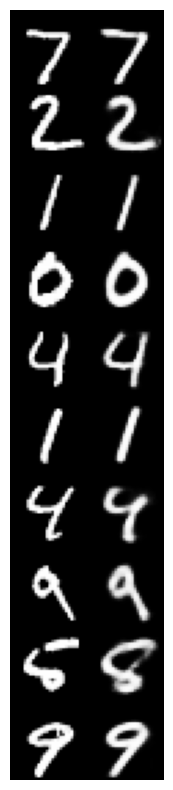

In [24]:
import matplotlib.pyplot as plt
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = x_reconstructed.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
z_embed = tsne.fit_transform(z)

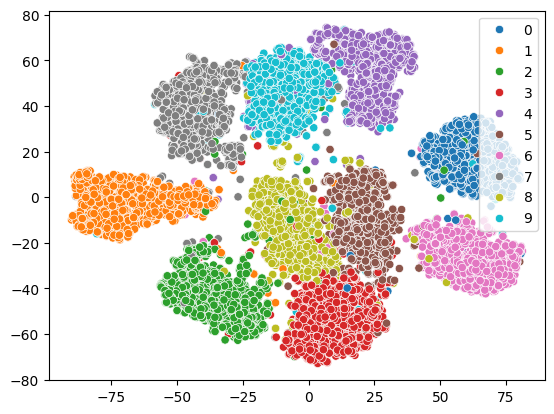

In [52]:
import seaborn as sns
N=10000
sns.scatterplot(x=z_embed[:N,0], y=z_embed[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()